In [1]:
import pandas as pd
import json
import eval_metrics as em
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score

Loading data

In [2]:
def get_results(folder_path):
    pred_data = pd.read_csv(f'./{folder_path}/pred.csv', names=["neutral", "happy", "angry", "sad"])
    truth_data = pd.read_csv(f'./{folder_path}/truth.csv', names=["neutral", "happy", "angry", "sad"])
    log = json.load(open(f'./{folder_path}/log.json'))
    pred = pred_data.values.tolist()
    truth = truth_data.values.tolist()
    return pred, truth, log

In [3]:
pred1, truth1, log1 = get_results("msp_prediction/zs_0con_withaudio")
pred2, truth2, log2 = get_results("msp_prediction/zs_0con_withaudio_(2)_1001")
pred3, truth3, log3 = get_results("msp_prediction/zs_0con_withaudio_(3)_1001")
pred4, truth4, log4 = get_results("msp_prediction/zs_0con_withaudio_(4)_1001")
pred5, truth5, log5 = get_results("msp_prediction/zs_0con_withaudio_(5)_1001")

assert truth1 == truth2 == truth3 == truth4 == truth5

Calculate the evaluation metrics

In [4]:
def get_eval(pred, truth):
    KL_dist = []
    R_square = []
    BC = []
    JS_distance = []
    for i in range(len(pred)):
        KL_dist.append(round(em.KL(pred[i], truth[i]),6))
        b_coefficient = em.BC(pred[i], truth[i])
        BC.append(round(b_coefficient,6))
        R_square.append(round(em.R(pred[i], truth[i]),6))
        JS_distance.append(round(em.js_distance(pred[i], truth[i]),6))

    eval_metrics = pd.DataFrame({
        'ground_truth': truth,
        'prediction': pred,
        'KL': KL_dist,
        'BC': BC,
        'R_square': R_square,
        'JS': JS_distance
    })
    eval_metrics['KL_std'] = round((eval_metrics['KL'] - eval_metrics['KL'].min()) / (eval_metrics['KL'].max() - eval_metrics['KL'].min()),6)
    eval_metrics['mj_pred'] = eval_metrics['prediction'].apply(lambda x: x.index(max(x)))
    eval_metrics['mj_gt'] = eval_metrics['ground_truth'].apply(lambda x: x.index(max(x)))
    return eval_metrics
    
def cal_entropy(emo_probs):
    emo_probs = np.array(emo_probs)
    non_0_probs = emo_probs[emo_probs > 0]
    entropy = abs(np.sum(non_0_probs*np.log2(non_0_probs)))
    return round(entropy,4)

def add_entropy(eval_metrics):
    entropy = []
    for i in range(len(eval_metrics)):
        entropy.append(cal_entropy(eval_metrics.iloc[i,0]))
    eval_metrics['entropy'] = entropy
    return eval_metrics

In [5]:
em1 = get_eval(pred1, truth1)
em1 = add_entropy(em1)

em2 = get_eval(pred2, truth2)
em2 = add_entropy(em2)

em3 = get_eval(pred3, truth3)
em3 = add_entropy(em3)

em4 = get_eval(pred4, truth4)
em4 = add_entropy(em4)

em5 = get_eval(pred5, truth5)
em5 = add_entropy(em5)

/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: divide by zero encountered in log
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: invalid value encountered in multiply
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: divide by zero encountered in log
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: invalid value encountered in multiply
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: divide by zero encountered in log
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/

In [6]:
import plotly.express as px
fig = px.histogram(em1, x="entropy", nbins=50)
fig.show()

# Whole work flow
## Ambiguous measurements
1. Concate performance of five rounds 
2. Filter 6 groups of entropy (instances>99)
3. For each evaluation metric (JS, BC, R square):
    - Calculate the variance of each instance
4. (By entropy groups) Calculate the mean and variance of the instance variance 
5. Calculate Variantion by entropy groups
    * Alternative measurement CV: eliminate the influence of different number of instances in each group

Mean of JS distance

In [7]:
print("Mean of JS distance")
js1 = np.mean(em1['JS'])
js2 = np.mean(em2['JS'])
js3 = np.mean(em3['JS'])
js4 = np.mean(em4['JS'])
js5 = np.mean(em5['JS'])

print("Round 1: ", round(js1,6))
print("Round 2: ", round(js2,6))
print("Round 3: ", round(js3,6))
print("Round 4: ", round(js4,6))
print("Round 5: ", round(js5,6))
print("variance: ", np.var([js1,js2,js3,js4,js5]))

Mean of JS distance
Round 1:  0.45734
Round 2:  0.456008
Round 3:  0.459047
Round 4:  0.458264
Round 5:  0.457181
variance:  1.0619959329009873e-06


Mean of JS by entropy group -> Variation of the means

In [8]:
entropy_list = em1.entropy.tolist()
filter_num = 89

In [9]:
def filter_em_data(filter_num, em_data, entropy_list):
    fil_entr = []
    for en in entropy_list:
        if len(em_data[em_data['entropy']==en]) > filter_num and en not in fil_entr:
            fil_entr.append(en)
    em_fil = em_data[em_data['entropy'].isin(fil_entr)].reset_index()
    return em_fil, fil_entr

In [10]:
em1_fil,fil_entr = filter_em_data(filter_num, em1, entropy_list)
em2_fil,fil_entr = filter_em_data(filter_num, em2, entropy_list)
em3_fil,fil_entr = filter_em_data(filter_num, em3, entropy_list)
em4_fil,fil_entr = filter_em_data(filter_num, em4, entropy_list)
em5_fil,fil_entr = filter_em_data(filter_num, em5, entropy_list)

In [11]:
em_js = pd.DataFrame({
    "entropy": em1_fil.entropy.tolist(),
    "JS1": em1_fil.JS.tolist(),
    "JS2": em2_fil.JS.tolist(),
    "JS3": em3_fil.JS.tolist(),
    "JS4": em4_fil.JS.tolist(),
    "JS5": em5_fil.JS.tolist()
})
em_js['mean'] = em_js.iloc[:,1:6].mean(axis=1)
em_js['Var'] = em_js.iloc[:,1:6].var(axis=1)
em_js['entropy'] == em_js['entropy'].astype(str)
em_js.head()

,entropy,JS1,JS2,JS3,JS4,JS5,mean,Var
0,0.9710,0.523784,0.523784,0.523784,0.523784,0.523784,0.523784,0.000000
1,0.9710,0.523784,0.523784,0.523784,0.523784,0.523784,0.523784,0.000000
2,0.9710,0.557898,0.832526,0.832526,0.832526,0.753691,0.761833,0.014162
3,0.7219,0.273679,0.273679,0.273679,0.273679,0.273679,0.273679,0.000000
4,0.7219,0.273679,0.273679,0.273679,0.273679,0.273679,0.273679,0.000000


In [12]:
em1_fil

,index,ground_truth,prediction,KL,BC,R_square,JS,KL_std,mj_pred,mj_gt,entropy
0,0,"[0.4, 0.6, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.9163,0.6325,0.1111,0.523784,0.049743,0,1,0.9710
1,1,"[0.6, 0.0, 0.0, 0.4]","[0.0, 0.0, 0.0, 1.0]",0.9163,0.6325,0.1111,0.523784,0.049743,3,0,0.9710
2,2,"[0.4, 0.6, 0.0, 0.0]","[0.8, 0.0, 0.0, 0.2]",3.9168,0.5657,0.0422,0.557898,0.212630,0,1,0.9710
3,3,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219
4,4,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219
...,...,...,...,...,...,...,...,...,...,...,...
3921,4109,"[0.4, 0.6, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.9163,0.6325,0.1111,0.523784,0.049743,0,1,0.9710
3922,4110,"[0.8, 0.0, 0.2, 0.0]","[0.0, 0.0, 1.0, 0.0]",1.6094,0.4472,0.0078,0.650231,0.087369,2,0,0.7219
3923,4111,"[0.0, 1.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",18.4207,0.0000,0.1111,0.832526,1.000000,0,1,0.0000
3924,4112,"[0.6, 0.0, 0.4, 0.0]","[0.9, 0.0, 0.0, 0.1]",1.9767,0.7348,0.5465,0.434051,0.107309,0,0,0.9710


In [13]:
em_js_fill = pd.DataFrame({
    "entropy": em1.entropy.tolist(),
    "JS1": em1.JS.tolist(),
    "JS2": em2.JS.tolist(),
    "JS3": em3.JS.tolist(),
    "JS4": em4.JS.tolist(),
    "JS5": em5.JS.tolist(),
    "gt": em1.ground_truth.tolist(),
    "JS1_pred": em1.prediction.tolist(),
    "JS2_pred": em2.prediction.tolist(),
    "JS3_pred": em3.prediction.tolist(),
    "JS4_pred": em4.prediction.tolist(),
    "JS5_pred": em5.prediction.tolist()
})
em_js_fill['mean'] = em_js_fill.iloc[:,1:6].mean(axis=1)
em_js_fill['Var'] = em_js_fill.iloc[:,1:6].var(axis=1)
em_js_fill['entropy'] == em_js_fill['entropy'].astype(str)

0       False
1       False
2       False
3       False
4       False
        ...  
4109    False
4110    False
4111    False
4112    False
4113    False
Name: entropy, Length: 4114, dtype: bool

In [14]:
em_r = pd.DataFrame({
    "entropy": em1.entropy.tolist(),
    "R1": em1.R_square.tolist(),
    "R2": em2.R_square.tolist(),
    "R3": em3.R_square.tolist(),
    "R4": em4.R_square.tolist(),
    "R5": em5.R_square.tolist()
})
em_r['mean'] = em_r.iloc[:,1:6].mean(axis=1)
em_r['Var'] = em_r.iloc[:,1:6].var(axis=1)
em_r['entropy'] == em_r['entropy'].astype(str)

0       False
1       False
2       False
3       False
4       False
        ...  
4109    False
4110    False
4111    False
4112    False
4113    False
Name: entropy, Length: 4114, dtype: bool

In [15]:
em_bc = pd.DataFrame({
    "entropy": em1.entropy.tolist(),
    "R1": em1.BC.tolist(),
    "R2": em2.BC.tolist(),
    "R3": em3.BC.tolist(),
    "R4": em4.BC.tolist(),
    "R5": em5.BC.tolist()
})
em_bc['mean'] = em_bc.iloc[:,1:6].mean(axis=1)
em_bc['Var'] = em_bc.iloc[:,1:6].var(axis=1)
em_bc['entropy'] == em_bc['entropy'].astype(str)

0       False
1       False
2       False
3       False
4       False
        ...  
4109    False
4110    False
4111    False
4112    False
4113    False
Name: entropy, Length: 4114, dtype: bool

In [16]:
em1[em1['entropy']>1.5219].entropy.value_counts()

entropy
1.9219    23
1.8038     2
1.8357     1
Name: count, dtype: int64

In [17]:
em_js_fill['num_class'] = em_js_fill['entropy'].apply(lambda x: '1' if x==0.0000 else '2' if x <= 0.9710 and x > 0.0000 else '3' if x > 0.9710 and x <= 1.5219 else '4')
em_js_fill = em_js_fill.sort_values(by='num_class')
em_js_fill.num_class.value_counts()
em_bc['num_class'] = em_bc['entropy'].apply(lambda x: '1' if x==0.0000 else '2' if x <= 0.9710 and x > 0.0000 else '3' if x > 0.9710 and x <= 1.5219 else '4')
em_bc = em_bc.sort_values(by='num_class')
em_r['num_class'] = em_r['entropy'].apply(lambda x: '1' if x==0.0000 else '2' if x <= 0.9710 and x > 0.0000 else '3' if x > 0.9710 and x <= 1.5219 else '4')
em_r = em_r.sort_values(by='num_class')

In [18]:
em_js_fill.groupby('num_class').count()
em_js_fill = em_js_fill[em_js_fill['num_class'].isin(['1','2','3'])]
em_bc = em_bc[em_bc['num_class'].isin(['1','2','3'])]
em_r = em_r[em_r['num_class'].isin(['1','2','3'])]

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/1108127340.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/1108127340.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/1108127340.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Figure size 640x480 with 0 Axes>

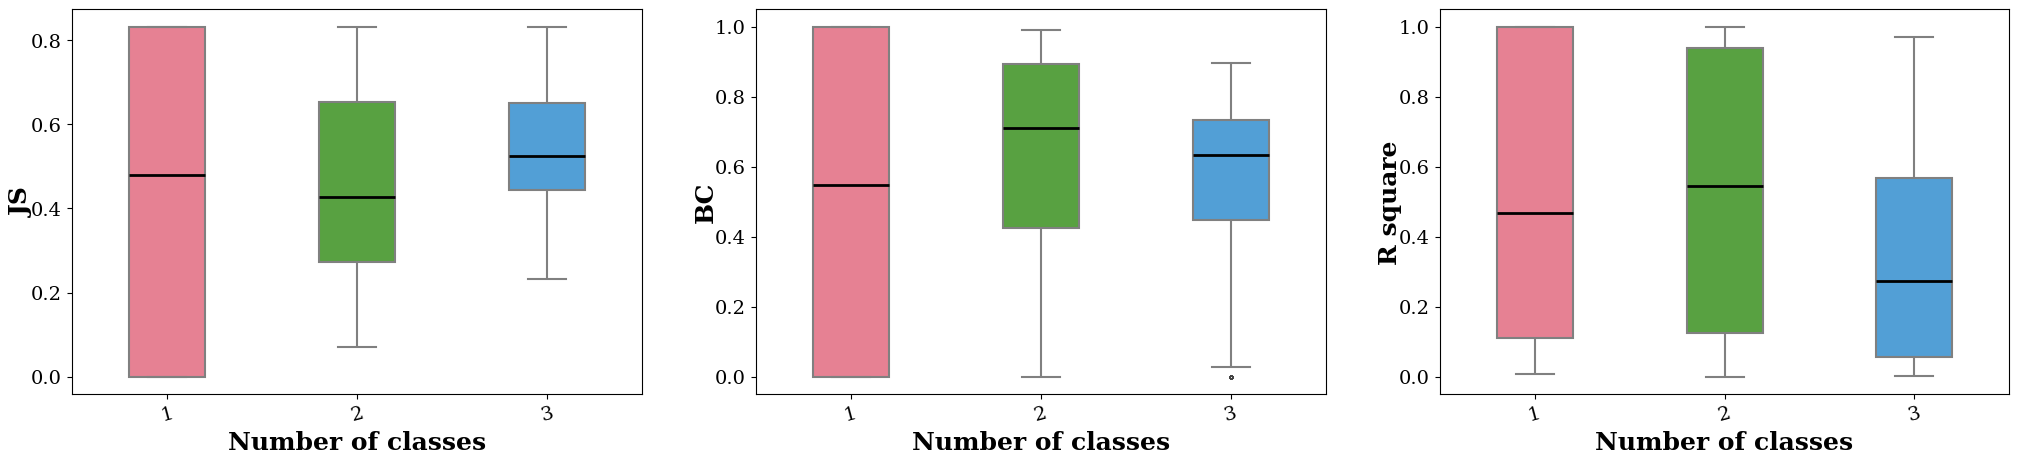

In [277]:
# def sns_vial(data):
plt.rcParams['font.family'] = 'serif'

plt.figure(facecolor='white')
palette = sns.color_palette("husl",3)  # 选择一个调色板

fig, axs = plt.subplots(1,3,figsize=(25,5))

boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='num_class', y='mean', data=em_js_fill,  ax=axs[0], palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
axs[0].set_ylabel('JS', fontsize = 18, labelpad=-2, fontweight='semibold')
axs[0].set_xlabel('Number of classes', fontsize = 18, fontweight='semibold')
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].tick_params(axis='x', labelrotation=15)

box2 = sns.boxplot(x='num_class', y='mean', data=em_bc,  ax=axs[1], palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
axs[1].set_ylabel('BC', fontsize = 18, labelpad=-2, fontweight='semibold')
axs[1].set_xlabel('Number of classes', fontsize = 18, fontweight='semibold')
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].tick_params(axis='x', labelrotation=15)
for i in [4, 10, 16]:  # 修改第一组、第二组和第三组的中位数线条
    box2.get_lines()[i].set_color(median_color)
    box2.get_lines()[i].set_linewidth(2)

box3 = sns.boxplot(x='num_class', y='mean', data=em_r,  ax=axs[2], palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
for i in [4, 10, 16]:  # 修改第一组、第二组和第三组的中位数线条
    box3.get_lines()[i].set_color(median_color)
    box3.get_lines()[i].set_linewidth(2)
axs[2].set_ylabel('R square', fontsize = 18, labelpad=-2,fontweight='semibold')
axs[2].set_xlabel('Number of classes', fontsize = 18, fontweight='semibold')
axs[2].tick_params(axis='both', which='major', labelsize=14)
axs[2].tick_params(axis='x', labelrotation=15)


plt.show()

In [254]:
em_js.head()

,entropy,JS1,JS2,JS3,JS4,JS5,mean,Var
0,0.9710,0.523784,0.523784,0.523784,0.523784,0.523784,0.523784,0.000000
1,0.9710,0.523784,0.523784,0.523784,0.523784,0.523784,0.523784,0.000000
2,0.9710,0.557898,0.832526,0.832526,0.832526,0.753691,0.761833,0.014162
3,0.7219,0.273679,0.273679,0.273679,0.273679,0.273679,0.273679,0.000000
4,0.7219,0.273679,0.273679,0.273679,0.273679,0.273679,0.273679,0.000000


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/3673753568.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




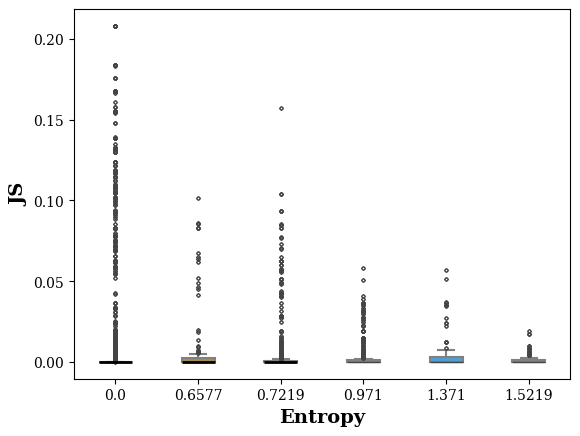

In [255]:
# def sns_vial(data):
plt.rcParams['font.family'] = 'serif'

plt.figure(facecolor='white')
palette = sns.color_palette("husl",6)  # 选择一个调色板

boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='entropy', y='Var', data=em_js, palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
# box1 = sns.boxplot(x='entropy', y = 'Var', data=em_js, palette=palette)
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
plt.ylabel('JS', fontsize = 14,  fontweight='semibold')
plt.xlabel('Entropy', fontsize = 14, fontweight='semibold')
# plt.tick_params(axis='both', which='major', labelsize=14)


#sns.despine(left=True)

plt.show()

In [256]:
em_js['min_max'] = em_js[['JS1', 'JS2', 'JS3', 'JS4', 'JS5']].max(axis=1) - em_js[["JS1", "JS2", "JS3", "JS4", "JS5"]].min(axis=1)

In [257]:
em_js

,entropy,JS1,JS2,JS3,JS4,JS5,mean,Var,min_max
0,0.9710,0.523784,0.523784,0.523784,0.523784,0.523784,0.523784,0.000000,0.000000
1,0.9710,0.523784,0.523784,0.523784,0.523784,0.523784,0.523784,0.000000,0.000000
2,0.9710,0.557898,0.832526,0.832526,0.832526,0.753691,0.761833,0.014162,0.274628
3,0.7219,0.273679,0.273679,0.273679,0.273679,0.273679,0.273679,0.000000,0.000000
4,0.7219,0.273679,0.273679,0.273679,0.273679,0.273679,0.273679,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
3921,0.9710,0.523784,0.523784,0.523784,0.523784,0.523784,0.523784,0.000000,0.000000
3922,0.7219,0.650231,0.650231,0.650231,0.650231,0.650231,0.650231,0.000000,0.000000
3923,0.0000,0.832526,0.832526,0.832526,0.832526,0.832526,0.832526,0.000000,0.000000
3924,0.9710,0.434051,0.463843,0.463843,0.463843,0.404784,0.446073,0.000699,0.059059


ValueError: Could not interpret value `num_class` for `x`. An entry with this name does not appear in `data`.

<Figure size 640x480 with 0 Axes>

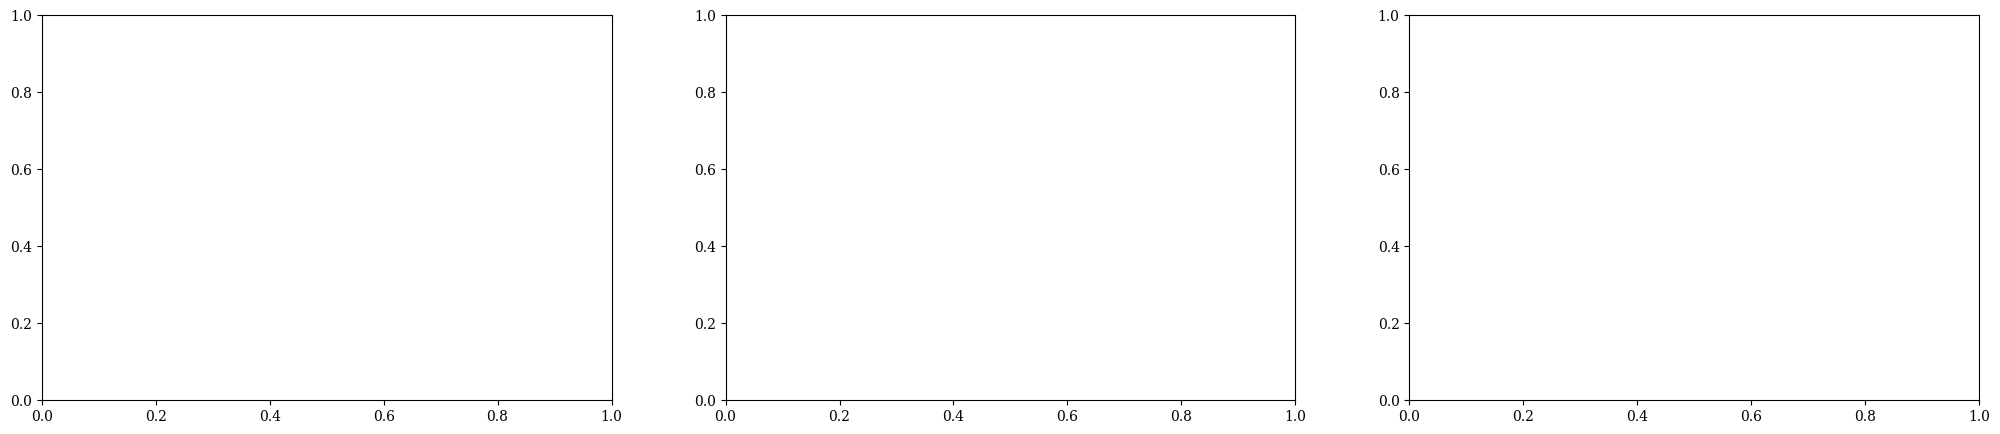

In [258]:
# def sns_vial(data):
plt.rcParams['font.family'] = 'serif'

plt.figure(facecolor='white')
palette = sns.color_palette("husl",3)  # 选择一个调色板

fig, axs = plt.subplots(1,3,figsize=(25,5))

boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='num_class', y='mean', data=em_js,  ax=axs[0], palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
axs[0].set_ylabel('JS', fontsize = 18, labelpad=-2, fontweight='semibold')
axs[0].set_xlabel('Number of classes', fontsize = 18, fontweight='semibold')
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].tick_params(axis='x', labelrotation=15)

box2 = sns.boxplot(x='num_class', y='mean', data=em_bc,  ax=axs[1], palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
axs[1].set_ylabel('BC', fontsize = 18, labelpad=-2, fontweight='semibold')
axs[1].set_xlabel('Number of classes', fontsize = 18, fontweight='semibold')
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].tick_params(axis='x', labelrotation=15)
for i in [4, 10, 16]:  # 修改第一组、第二组和第三组的中位数线条
    box2.get_lines()[i].set_color(median_color)
    box2.get_lines()[i].set_linewidth(2)

box3 = sns.boxplot(x='num_class', y='mean', data=em_r,  ax=axs[2], palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
for i in [4, 10, 16]:  # 修改第一组、第二组和第三组的中位数线条
    box3.get_lines()[i].set_color(median_color)
    box3.get_lines()[i].set_linewidth(2)
axs[2].set_ylabel('R square', fontsize = 18, labelpad=-2,fontweight='semibold')
axs[2].set_xlabel('Number of classes', fontsize = 18, fontweight='semibold')
axs[2].tick_params(axis='both', which='major', labelsize=14)
axs[2].tick_params(axis='x', labelrotation=15)


plt.show()

In [ ]:
em_js.groupby("entropy").Var.count()

entropy
0.0000    2711
0.6577     144
0.7219     537
0.9710     335
1.3710      98
1.5219     101
Name: Var, dtype: int64

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/2416730628.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/2416730628.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




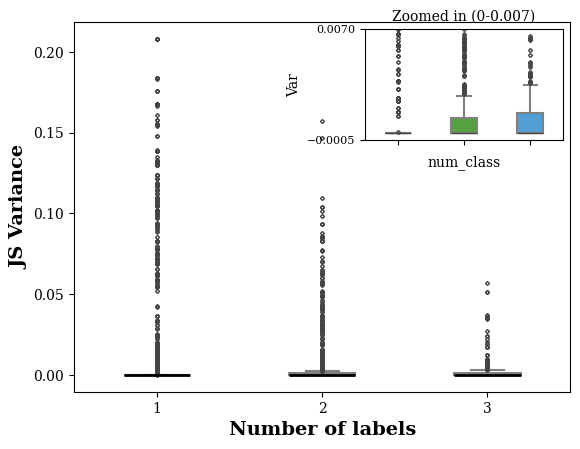

In [ ]:
# def sns_vial(data):
plt.rcParams['font.family'] = 'serif'

plt.figure(facecolor='white')
palette = sns.color_palette("husl",3)  # 选择一个调色板

boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='num_class', y='Var', data=em_js_fill, palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
# box1 = sns.boxplot(x='entropy', y = 'Var', data=em_js, palette=palette)
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
plt.ylabel('JS Variance', fontsize = 14,  fontweight='semibold')
plt.xlabel('Number of labels', fontsize = 14, fontweight='semibold')
# plt.tick_params(axis='both', which='major', labelsize=14)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

inset = inset_axes(box1, width="40%", height="30%", loc="upper right")  # inset axes
sns.boxplot(x='num_class', y='Var', data=em_js_fill, palette=palette, width=0.4,
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, ax=inset)

# Set limits for inset
inset.set_ylim(-0.0005, 0.007)
inset.set_yticks([-0.0005, 0.007])
inset.tick_params(axis='y', which='major', labelsize=8)
inset.set_xticklabels([])  # Hide x-axis labels on inset
inset.set_title("Zoomed in (0-0.007)", fontsize=10)


#sns.despine(left=True)

plt.show()

,ground_truth,prediction,KL,BC,R_square,JS,KL_std,mj_pred,mj_gt,entropy
0,"[0.4, 0.6, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.9163,0.6325,0.1111,0.523784,0.049743,0,1,0.9710
1,"[0.6, 0.0, 0.0, 0.4]","[0.0, 0.0, 0.0, 1.0]",0.9163,0.6325,0.1111,0.523784,0.049743,3,0,0.9710
2,"[0.4, 0.6, 0.0, 0.0]","[0.8, 0.0, 0.0, 0.2]",3.9168,0.5657,0.0422,0.557898,0.212630,0,1,0.9710
3,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219
4,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219
...,...,...,...,...,...,...,...,...,...,...
4109,"[0.4, 0.6, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.9163,0.6325,0.1111,0.523784,0.049743,0,1,0.9710
4110,"[0.8, 0.0, 0.2, 0.0]","[0.0, 0.0, 1.0, 0.0]",1.6094,0.4472,0.0078,0.650231,0.087369,2,0,0.7219
4111,"[0.0, 1.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",18.4207,0.0000,0.1111,0.832526,1.000000,0,1,0.0000
4112,"[0.6, 0.0, 0.4, 0.0]","[0.9, 0.0, 0.0, 0.1]",1.9767,0.7348,0.5465,0.434051,0.107309,0,0,0.9710


In [ ]:
for i, pack in enumerate(log1):
    if i == 3069:
        print(pack) 
        print(log1[pack])   

MSP-PODCAST_2329_0398
["Here is a podcast transcript: '...let's just say to buy a rental property. now i'm a-'.Please find useful information from the 88 audio features from the target sentence as references. The features are:{'Average Fundamental Frequency in Semitones from 27.5 Hz': 21.752174377441406, 'Normalized Standard Deviation of Fundamental Frequency in Semitones from 27.5 Hz': 0.13160377740859985, '20th Percentile of Fundamental Frequency in Semitones from 27.5 Hz': 21.665306091308594, '50th Percentile (Median) of Fundamental Frequency in Semitones from 27.5 Hz': 22.400197982788086, '80th Percentile of Fundamental Frequency in Semitones from 27.5 Hz': 23.255603790283203, 'Range of Fundamental Frequency in Semitones from 0th to 2nd Percentile': 1.5902976989746094, 'Mean Slope of Rising Fundamental Frequency in Semitones': 23.509090423583984, 'Standard Deviation of Rising Slopes of Fundamental Frequency in Semitones': 18.807598114013672, 'Mean Slope of Falling Fundamental Frequ

In [ ]:
em_js_fill.loc[0,'gt']

[0.4, 0.6, 0.0, 0.0]

In [ ]:
np.argmax(em_js_fill.loc[0,'gt'])

1

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/975708268.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/975708268.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(array([71.,  0.,  1.,  0.,  1.,  1.,  2.,  1.,  1.,  1.]),
 array([0.        , 0.01236466, 0.02472933, 0.03709399, 0.04945865,
        0.06182331, 0.07418798, 0.08655264, 0.0989173 , 0.11128196,
        0.12364663]),
 <BarContainer object of 10 artists>)

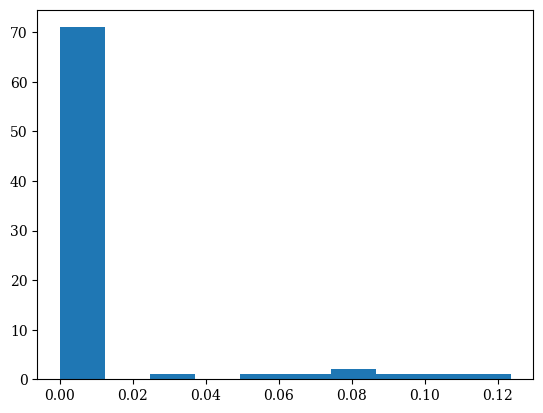

In [ ]:
em_js_fill_1 = em_js_fill[em_js_fill['num_class']==str(1)]
em_js_fill_1['gt_class'] = em_js_fill_1['gt'].apply(lambda x: np.argmax(x))
em_js_fill_1['gt_label'] = em_js_fill_1['gt_class'].apply(lambda x: 'neutral' if x == 0 else 'happy' if x == 1 else 'angry' if x == 2 else 'sad')
plt.hist(em_js_fill_1[em_js_fill_1['gt_label']== 'sad'].Var)

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/3736624126.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/3736624126.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(array([90.,  0.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  1.]),
 array([0.        , 0.02079299, 0.04158597, 0.06237896, 0.08317194,
        0.10396493, 0.12475792, 0.1455509 , 0.16634389, 0.18713688,
        0.20792986]),
 <BarContainer object of 10 artists>)

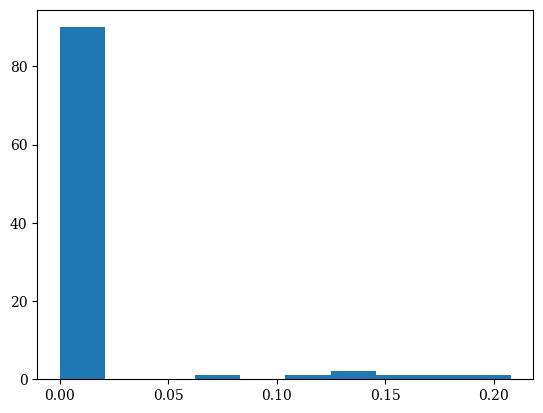

In [ ]:
em_js_fill_1 = em_js_fill[em_js_fill['num_class']==str(1)]
em_js_fill_1['gt_class'] = em_js_fill_1['gt'].apply(lambda x: np.argmax(x))
em_js_fill_1['gt_label'] = em_js_fill_1['gt_class'].apply(lambda x: 'neutral' if x == 0 else 'happy' if x == 1 else 'angry' if x == 2 else 'sad')
plt.hist(em_js_fill_1[em_js_fill_1['gt_label']== 'angry'].Var)

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/659109762.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/659109762.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(array([808.,   1.,   3.,   5.,   2.,   6.,   7.,   4.,   4.,   5.]),
 array([0.        , 0.02079299, 0.04158597, 0.06237896, 0.08317194,
        0.10396493, 0.12475792, 0.1455509 , 0.16634389, 0.18713688,
        0.20792986]),
 <BarContainer object of 10 artists>)

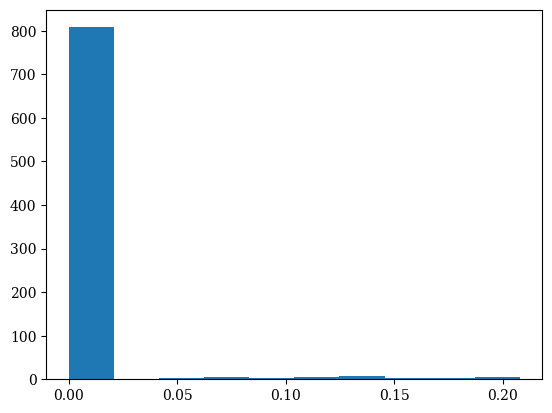

In [ ]:
em_js_fill_1 = em_js_fill[em_js_fill['num_class']==str(1)]
em_js_fill_1['gt_class'] = em_js_fill_1['gt'].apply(lambda x: np.argmax(x))
em_js_fill_1['gt_label'] = em_js_fill_1['gt_class'].apply(lambda x: 'neutral' if x == 0 else 'happy' if x == 1 else 'angry' if x == 2 else 'sad')
plt.hist(em_js_fill_1[em_js_fill_1['gt_label']== 'happy'].Var)

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/404735565.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/404735565.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(array([1496.,   14.,   11.,   51.,   14.,   36.,   38.,    6.,   12.,
          12.]),
 array([0.        , 0.02079299, 0.04158597, 0.06237896, 0.08317194,
        0.10396493, 0.12475792, 0.1455509 , 0.16634389, 0.18713688,
        0.20792986]),
 <BarContainer object of 10 artists>)

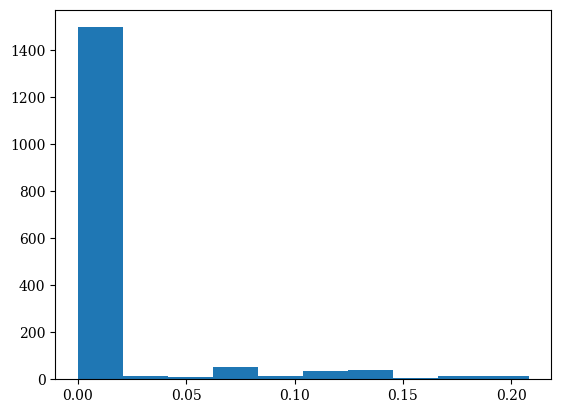

In [ ]:
em_js_fill_1 = em_js_fill[em_js_fill['num_class']==str(1)]
em_js_fill_1['gt_class'] = em_js_fill_1['gt'].apply(lambda x: np.argmax(x))
em_js_fill_1['gt_label'] = em_js_fill_1['gt_class'].apply(lambda x: 'neutral' if x == 0 else 'happy' if x == 1 else 'angry' if x == 2 else 'sad')
plt.hist(em_js_fill_1[em_js_fill_1['gt_label']== 'neutral'].Var)

In [ ]:
em_js_fill_1['gt'].value_counts()

gt
[1.0, 0.0, 0.0, 0.0]    1690
[0.0, 1.0, 0.0, 0.0]     845
[0.0, 0.0, 1.0, 0.0]      97
[0.0, 0.0, 0.0, 1.0]      79
Name: count, dtype: int64

In [ ]:
c_1_q75 = em_js_fill[em_js_fill['num_class'] == str(1)].Var.quantile(0.75)
em_js_fill[(em_js_fill['num_class'] == str(1))& em_js_fill['Var'] > c_1_q75]['gt_label'].value_counts()

gt_label
neutral    527
happy       90
sad         24
angry       15
Name: count, dtype: int64

In [ ]:
print("Number of class: 1")
print(527/1690), print(90/845), print(24/97), print(15/79)

Number of class: 1
0.3118343195266272
0.10650887573964497
0.24742268041237114
0.189873417721519


(None, None, None, None)

In [ ]:
em_js_fill['gt_class'] = em_js_fill['gt'].apply(lambda x: np.argmax(x))
em_js_fill['gt_label'] = em_js_fill['gt_class'].apply(lambda x: 'neutral' if x == 0 else 'happy' if x == 1 else 'angry' if x == 2 else 'sad')
# plt.hist(em_js_fill[em_js_fill['gt_label']== 'happy'].Var)

In [ ]:
em_js_fill[em_js_fill['num_class'] == str(2)]['gt_label'].value_counts()

gt_label
neutral    591
happy      422
sad         57
angry       53
Name: count, dtype: int64

In [ ]:
c_2_q75 = em_js_fill[em_js_fill['num_class'] == str(2)].Var.quantile(0.75)

In [ ]:
em_js_fill[(em_js_fill['num_class'] == str(2))& em_js_fill['Var'] > c_2_q75]['gt_label'].value_counts()

gt_label
neutral    191
happy      154
sad         14
angry       13
Name: count, dtype: int64

In [ ]:
print("number of classes: 2")
print(191/591,154/422,14/57,13/53)

number of classes: 2
0.32318104906937395 0.36492890995260663 0.24561403508771928 0.24528301886792453


In [ ]:
em_js_fill[em_js_fill['num_class'] == str(3)]['gt_label'].value_counts()

gt_label
neutral    169
happy       62
sad         13
angry       10
Name: count, dtype: int64

In [ ]:
c_3_q75 = em_js_fill[em_js_fill['num_class'] == str(3)].Var.quantile(0.75)
em_js_fill[(em_js_fill['num_class'] == str(3))& em_js_fill['Var'] > c_3_q75]['gt_label'].value_counts()

gt_label
neutral    79
happy      16
sad         9
angry       5
Name: count, dtype: int64

In [ ]:
print("number of classes: 3")
print(79/169, 16/62, 9/13, 5/10)

number of classes: 3
0.46745562130177515 0.25806451612903225 0.6923076923076923 0.5


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/3560176037.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/3560176037.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




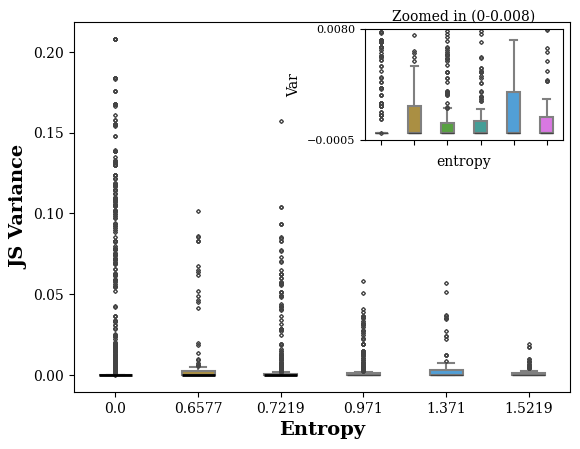

In [ ]:
# def sns_vial(data):
plt.rcParams['font.family'] = 'serif'

plt.figure(facecolor='white')
palette = sns.color_palette("husl",6)  # 选择一个调色板

boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='entropy', y='Var', data=em_js, palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
# box1 = sns.boxplot(x='entropy', y = 'Var', data=em_js, palette=palette)
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
plt.ylabel('JS Variance', fontsize = 14,  fontweight='semibold')
plt.xlabel('Entropy', fontsize = 14, fontweight='semibold')
# plt.tick_params(axis='both', which='major', labelsize=14)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

inset = inset_axes(box1, width="40%", height="30%", loc="upper right")  # inset axes
sns.boxplot(x='entropy', y='Var', data=em_js, palette=palette, width=0.4,
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, ax=inset)

# Set limits for inset
inset.set_ylim(-0.0005, 0.008)
inset.set_yticks([-0.0005, 0.008])
inset.tick_params(axis='y', which='major', labelsize=8)
inset.set_xticklabels([])  # Hide x-axis labels on inset
inset.set_title("Zoomed in (0-0.008)", fontsize=10)


#sns.despine(left=True)

plt.show()

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/2620640668.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_17632/2620640668.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




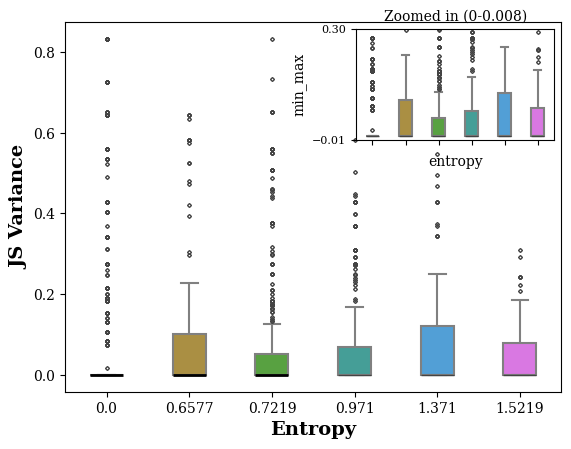

In [ ]:
# def sns_vial(data):
plt.rcParams['font.family'] = 'serif'

plt.figure(facecolor='white')
palette = sns.color_palette("husl",6)  # 选择一个调色板

boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='entropy', y='min_max', data=em_js, palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
# box1 = sns.boxplot(x='entropy', y = 'Var', data=em_js, palette=palette)
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
plt.ylabel('JS Variance', fontsize = 14,  fontweight='semibold')
plt.xlabel('Entropy', fontsize = 14, fontweight='semibold')
# plt.tick_params(axis='both', which='major', labelsize=14)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

inset = inset_axes(box1, width="40%", height="30%", loc="upper right")  # inset axes
sns.boxplot(x='entropy', y='min_max', data=em_js, palette=palette, width=0.4,
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, ax=inset)

# Set limits for inset
inset.set_ylim(-0.01, 0.3)
inset.set_yticks([-0.01, 0.3])
inset.tick_params(axis='y', which='major', labelsize=8)
inset.set_xticklabels([])  # Hide x-axis labels on inset
inset.set_title("Zoomed in (0-0.008)", fontsize=10)


#sns.despine(left=True)

plt.show()

In [ ]:
mean_js = em_js.groupby("entropy").Var.mean().reset_index()
mean_js['entropy'] = mean_js['entropy'].astype(str)
mean_js

,entropy,Var
0,0.0,0.011330
1,0.6577,0.008116
2,0.7219,0.007022
3,0.971,0.003746
4,1.371,0.005104
5,1.5219,0.001532


Text(0, 0.5, 'JS')

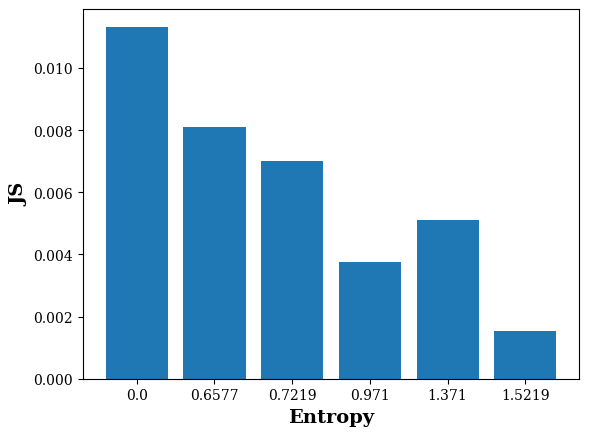

In [ ]:
plt.bar(mean_js['entropy'], mean_js['Var'])
plt.xlabel('Entropy', fontsize = 14, fontweight='semibold')
plt.ylabel('JS', fontsize = 14,  fontweight='semibold')
# plt.title("The mean of JS by entropy group")

BC

In [ ]:
em1_fil.head()

,index,ground_truth,prediction,KL,BC,R_square,JS,KL_std,mj_pred,mj_gt,entropy
0,0,"[0.4, 0.6, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.9163,0.6325,0.1111,0.523784,0.049743,0,1,0.9710
1,1,"[0.6, 0.0, 0.0, 0.4]","[0.0, 0.0, 0.0, 1.0]",0.9163,0.6325,0.1111,0.523784,0.049743,3,0,0.9710
2,2,"[0.4, 0.6, 0.0, 0.0]","[0.8, 0.0, 0.0, 0.2]",3.9168,0.5657,0.0422,0.557898,0.212630,0,1,0.9710
3,3,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219
4,4,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219


In [ ]:
em_bc = pd.DataFrame({
    "entropy": em1_fil.entropy.tolist(),
    "BC1": em1_fil.BC.tolist(),
    "BC2": em2_fil.BC.tolist(),
    "BC3": em3_fil.BC.tolist(),
    "BC4": em4_fil.BC.tolist(),
    "BC5": em5_fil.BC.tolist()
})
em_bc['mean'] = em_bc.iloc[:,1:6].mean(axis=1)
em_bc['Var'] = em_bc.iloc[:,1:6].var(axis=1)
print("Mean of instance variance")
em_bc.groupby("entropy").std().mean()

Mean of instance variance


BC1     0.322980
BC2     0.322894
BC3     0.325132
BC4     0.321433
BC5     0.323713
mean    0.307752
Var     0.035691
dtype: float64

R square

In [ ]:
em_r = pd.DataFrame({
    "entropy": em1_fil.entropy.tolist(),
    "R1": em1_fil.R_square.tolist(),
    "R2": em2_fil.R_square.tolist(),
    "R3": em3_fil.R_square.tolist(),
    "R4": em4_fil.R_square.tolist(),
    "R5": em5_fil.R_square.tolist()
})
em_r['mean'] = em_r.iloc[:,1:6].mean(axis=1)
em_r['Var'] = em_r.iloc[:,1:6].var(axis=1)
em_r['STD'] = em_r.iloc[:,1:6].std(axis=1)
print("Mean of instance variance")
em_r.groupby("entropy").Var.mean()

Mean of instance variance


entropy
0.0000    0.016979
0.6577    0.021077
0.7219    0.019930
0.9710    0.005651
1.3710    0.020456
1.5219    0.004771
Name: Var, dtype: float64

Concat evaluation metrics

In [ ]:
num = em1_fil.groupby("entropy").JS.count()
num

entropy
0.0000    2711
0.6577     144
0.7219     537
0.9710     335
1.3710      98
1.5219     101
Name: JS, dtype: int64

1. JS: boxplot
2. acc/f1-score: by number of emotion class
3. two classess: class combination: C42 = 6
    * (H+S), (H+N), (H+A), (S+A), ... by JS, acc
    * number of otterence 
4. investigate LLM randomness    
Conclusion: LLM may know when accuracy is high, it will consistence predict well. On the other hand, when accuracy is low, it will be random.

In [ ]:
em1_fil.head()

,index,ground_truth,prediction,KL,BC,R_square,JS,KL_std,mj_pred,mj_gt,entropy
0,0,"[0.4, 0.6, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.9163,0.6325,0.1111,0.523784,0.049743,0,1,0.9710
1,1,"[0.6, 0.0, 0.0, 0.4]","[0.0, 0.0, 0.0, 1.0]",0.9163,0.6325,0.1111,0.523784,0.049743,3,0,0.9710
2,2,"[0.4, 0.6, 0.0, 0.0]","[0.8, 0.0, 0.0, 0.2]",3.9168,0.5657,0.0422,0.557898,0.212630,0,1,0.9710
3,3,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219
4,4,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219


In [ ]:
em1_fil_7219 = em1_fil[em1_fil['entropy']==0.7219]
em1_fil_7219.head()

,index,ground_truth,prediction,KL,BC,R_square,JS,KL_std,mj_pred,mj_gt,entropy
3,3,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219
4,4,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219
8,8,"[0.8, 0.2, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219
11,11,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219
12,12,"[0.8, 0.0, 0.0, 0.2]","[0.0, 0.0, 0.0, 1.0]",1.6094,0.4472,0.0078,0.650231,0.087369,3,0,0.7219


In [ ]:
emotions = ['neutral', 'happy', 'angry', 'sad']

In [ ]:
em1_fil_7219['emo_labels'] = em1_fil_7219['ground_truth'].apply(lambda x: ', '.join(emotions[index] for index in range(4) if x[index] != 0.0))
em1_fil_7219.head()

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_916/3454452322.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,ground_truth,prediction,KL,BC,R_square,JS,KL_std,mj_pred,mj_gt,entropy,emo_labels
3,3,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219,"neutral, sad"
4,4,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219,"neutral, sad"
8,8,"[0.8, 0.2, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219,"neutral, happy"
11,11,"[0.8, 0.0, 0.0, 0.2]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219,"neutral, sad"
12,12,"[0.8, 0.0, 0.0, 0.2]","[0.0, 0.0, 0.0, 1.0]",1.6094,0.4472,0.0078,0.650231,0.087369,3,0,0.7219,"neutral, sad"


In [ ]:
em1_fil_7219['emo_labels'].value_counts()

emo_labels
neutral, happy    356
neutral, sad       97
neutral, angry     43
happy, sad         28
happy, angry       11
angry, sad          2
Name: count, dtype: int64

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_916/2443328319.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




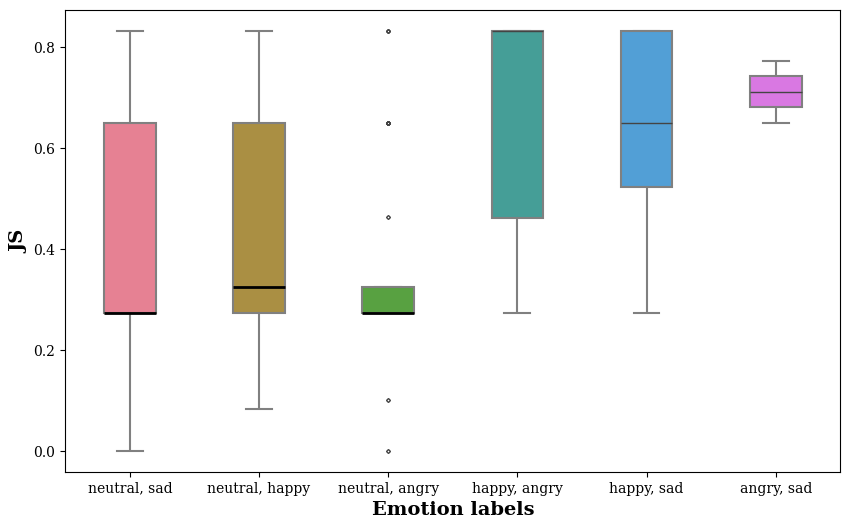

In [ ]:
# def sns_vial(data):
plt.rcParams['font.family'] = 'serif'

plt.figure(facecolor='white', figsize=(10,6))
palette = sns.color_palette("husl",6)  # 选择一个调色板


boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='emo_labels', y='JS', data=em1_fil_7219, palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
# box1 = sns.boxplot(x='entropy', y = 'Var', data=em_js, palette=palette)
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
plt.ylabel('JS', fontsize = 14,  fontweight='semibold')
plt.xlabel('Emotion labels', fontsize = 14, fontweight='semibold')
# plt.tick_params(axis='both', which='major', labelsize=14)


#sns.despine(left=True)
plt.show()

In [ ]:
emo_groups = em1_fil_7219.emo_labels.unique().tolist()
accs = []
f1s = []
for emo in emo_groups:
    gt_label = em1_fil_7219[em1_fil_7219['emo_labels']==emo].mj_gt
    pred_label = em1_fil_7219[em1_fil_7219['emo_labels']==emo].mj_pred
    acc = round(accuracy_score(gt_label,pred_label)*100,2)
    accs.append(acc)
    f1 = round(f1_score(gt_label,pred_label, labels=np.unique(pred_label), average="weighted")*100, 2)
    f1s.append(f1)
acc_f1_7219 = pd.DataFrame({
    "emo_group": emo_groups,
    "acc": accs,
    "f1": f1s
})
acc_f1_7219

,emo_group,acc,f1
0,"neutral, sad",63.92,68.96
1,"neutral, happy",53.65,54.00
2,"neutral, angry",81.40,85.03
3,"happy, angry",27.27,36.36
4,"happy, sad",25.00,26.67
5,"angry, sad",0.00,0.00


<BarContainer object of 6 artists>

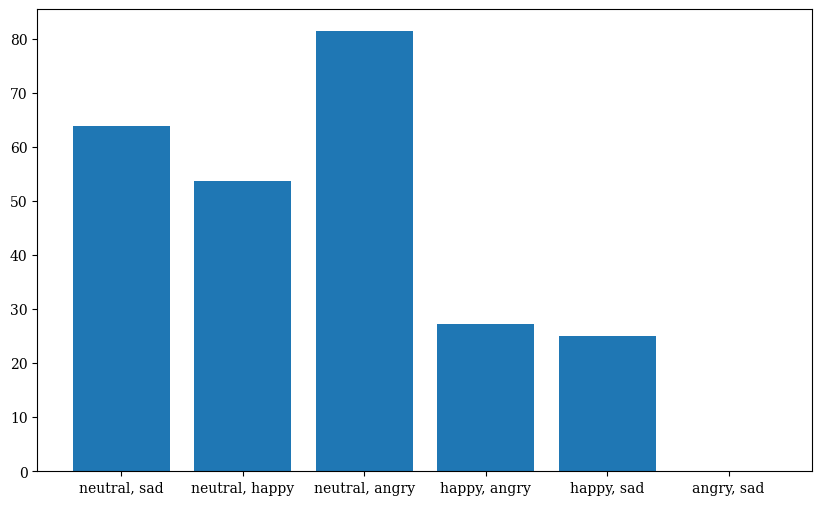

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(acc_f1_7219.emo_group, acc_f1_7219.acc)

In [ ]:
em1_fil_7219[em1_fil_7219['emo_labels']=='neutral, angry']

,index,ground_truth,prediction,KL,BC,R_square,JS,KL_std,mj_pred,mj_gt,entropy,emo_labels
32,33,"[0.8, 0.0, 0.2, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219,"neutral, angry"
91,94,"[0.8, 0.0, 0.2, 0.0]","[0.6, 0.0, 0.0, 0.4]",6.8291,0.6928,0.4556,0.463843,0.370730,0,0,0.7219,"neutral, angry"
148,154,"[0.8, 0.0, 0.2, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219,"neutral, angry"
155,162,"[0.8, 0.0, 0.2, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219,"neutral, angry"
262,277,"[0.8, 0.0, 0.2, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219,"neutral, angry"
291,309,"[0.8, 0.0, 0.2, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219,"neutral, angry"
300,319,"[0.8, 0.0, 0.2, 0.0]","[1.0, 0.0, 0.0, 0.0]",0.2231,0.8944,0.9380,0.273679,0.012111,0,0,0.7219,"neutral, angry"
358,383,"[0.8, 0.0, 0.2, 0.0]","[0.9, 0.0, 0.0, 0.1]",1.7178,0.8485,0.9013,0.324731,0.093254,0,0,0.7219,"neutral, angry"
436,468,"[0.8, 0.0, 0.2, 0.0]","[0.0, 0.0, 1.0, 0.0]",1.6094,0.4472,0.0078,0.650231,0.087369,2,0,0.7219,"neutral, angry"
472,509,"[0.8, 0.0, 0.2, 0.0]","[0.9, 0.0, 0.0, 0.1]",1.7178,0.8485,0.9013,0.324731,0.093254,0,0,0.7219,"neutral, angry"


In [ ]:
na_index = em1_fil_7219[em1_fil_7219['emo_labels']=='neutral, angry'].index.tolist()
for i, podcast_id in enumerate(log1):
    if i in na_index:
        print(podcast_id)
        print(log1[podcast_id])

MSP-PODCAST_0046_0038
["Here is a podcast transcript: ' and when you have nothing financially to lose, really, you can, let the imagination go free. and that's one of the joys of this milieu of '.Please find useful information from the 88 audio features from the target sentence as references. The features are:{'Average Fundamental Frequency in Semitones from 27.5 Hz': 23.87919807434082, 'Normalized Standard Deviation of Fundamental Frequency in Semitones from 27.5 Hz': 0.12029606848955154, '20th Percentile of Fundamental Frequency in Semitones from 27.5 Hz': 21.55105972290039, '50th Percentile (Median) of Fundamental Frequency in Semitones from 27.5 Hz': 23.462547302246094, '80th Percentile of Fundamental Frequency in Semitones from 27.5 Hz': 25.978199005126953, 'Range of Fundamental Frequency in Semitones from 0th to 2nd Percentile': 4.4271392822265625, 'Mean Slope of Rising Fundamental Frequency in Semitones': 162.82594299316406, 'Standard Deviation of Rising Slopes of Fundamental Fr

In [ ]:
em1_fil_6577 = em1_fil[em1_fil['entropy']==0.6577]
em1_fil_6577['emo_labels'] = em1_fil_6577['ground_truth'].apply(lambda x: ', '.join(emotions[index] for index in range(4) if x[index] != 0.0))
em1_fil_6577['emo_labels'].value_counts()

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_916/3110010102.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



emo_labels
neutral, happy    70
happy, angry      25
neutral, sad      15
happy, sad        14
neutral, angry    12
angry, sad         8
Name: count, dtype: int64

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_916/1361678907.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




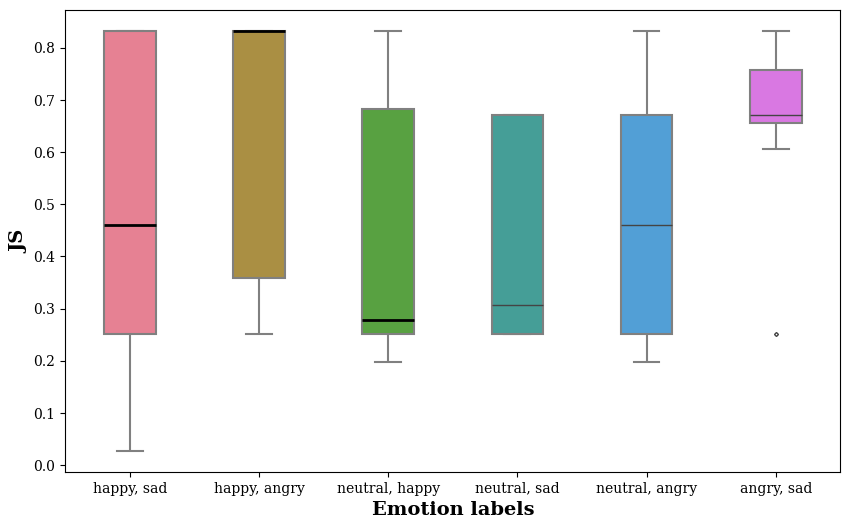

<BarContainer object of 6 artists>

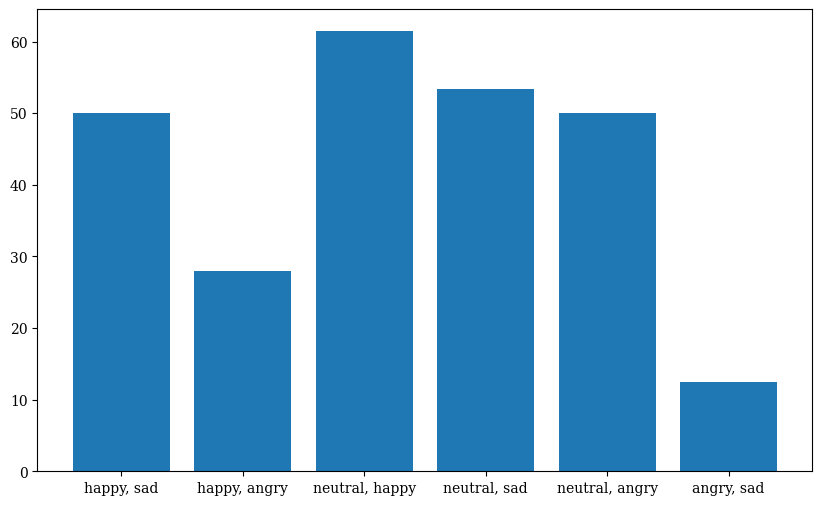

In [ ]:
# def sns_vial(data):
plt.rcParams['font.family'] = 'serif'

plt.figure(facecolor='white', figsize=(10,6))
palette = sns.color_palette("husl",6)  # 选择一个调色板


boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='emo_labels', y='JS', data=em1_fil_6577, palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
# box1 = sns.boxplot(x='entropy', y = 'Var', data=em_js, palette=palette)
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
plt.ylabel('JS', fontsize = 14,  fontweight='semibold')
plt.xlabel('Emotion labels', fontsize = 14, fontweight='semibold')
# plt.tick_params(axis='both', which='major', labelsize=14)


#sns.despine(left=True)
plt.show()

emo_groups = em1_fil_6577.emo_labels.unique().tolist()
accs = []
f1s = []
for emo in emo_groups:
    gt_label = em1_fil_6577[em1_fil_6577['emo_labels']==emo].mj_gt
    pred_label = em1_fil_6577[em1_fil_6577['emo_labels']==emo].mj_pred
    acc = round(accuracy_score(gt_label,pred_label)*100,2)
    accs.append(acc)
    f1 = round(f1_score(gt_label,pred_label, labels=np.unique(pred_label), average="weighted")*100, 2)
    f1s.append(f1)
em1_fil_6577 = pd.DataFrame({
    "emo_group": emo_groups,
    "acc": accs,
    "f1": f1s
})

plt.figure(figsize=(10,6))
plt.bar(em1_fil_6577.emo_group, em1_fil_6577.acc)

In [ ]:
em1_fil_9710 = em1_fil[em1_fil['entropy']==0.9710]
em1_fil_9710['emo_labels'] = em1_fil_9710['ground_truth'].apply(lambda x: ', '.join(emotions[index] for index in range(4) if x[index] != 0.0))
em1_fil_9710['emo_labels'].value_counts()

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_916/1013111978.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



emo_labels
neutral, happy    270
neutral, sad       49
neutral, angry      7
happy, angry        3
happy, sad          3
angry, sad          3
Name: count, dtype: int64

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_916/4034978947.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




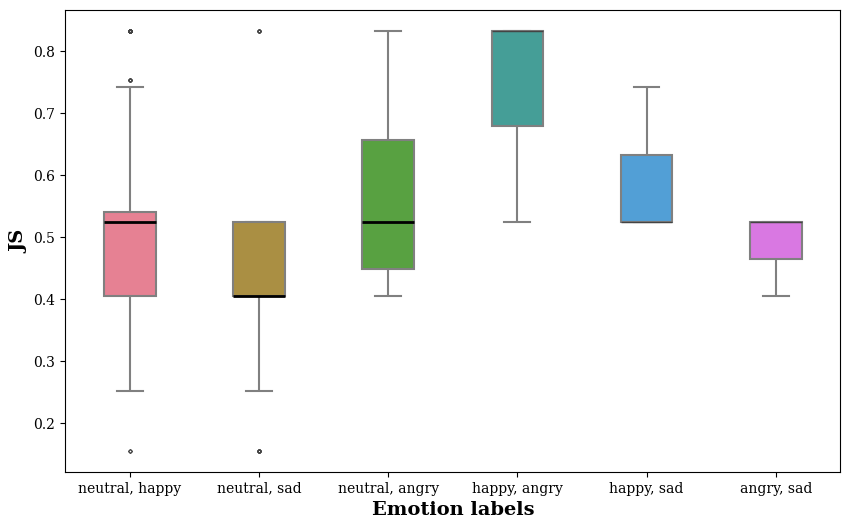

<BarContainer object of 6 artists>

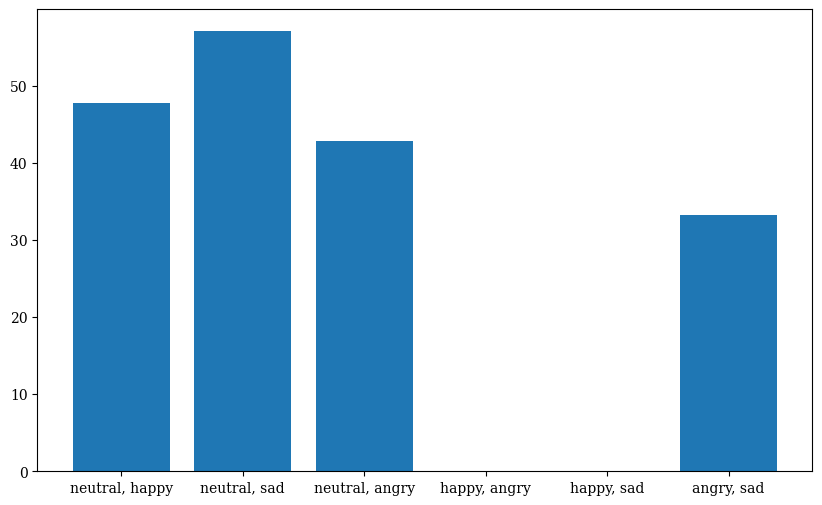

In [ ]:
# def sns_vial(data):
plt.rcParams['font.family'] = 'serif'

plt.figure(facecolor='white', figsize=(10,6))
palette = sns.color_palette("husl",6)  # 选择一个调色板


boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='emo_labels', y='JS', data=em1_fil_9710, palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
# box1 = sns.boxplot(x='entropy', y = 'Var', data=em_js, palette=palette)
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
plt.ylabel('JS', fontsize = 14,  fontweight='semibold')
plt.xlabel('Emotion labels', fontsize = 14, fontweight='semibold')
# plt.tick_params(axis='both', which='major', labelsize=14)


#sns.despine(left=True)
plt.show()

emo_groups = em1_fil_9710.emo_labels.unique().tolist()
accs = []
f1s = []
for emo in emo_groups:
    gt_label = em1_fil_9710[em1_fil_9710['emo_labels']==emo].mj_gt
    pred_label = em1_fil_9710[em1_fil_9710['emo_labels']==emo].mj_pred
    acc = round(accuracy_score(gt_label,pred_label)*100,2)
    accs.append(acc)
    f1 = round(f1_score(gt_label,pred_label, labels=np.unique(pred_label), average="weighted")*100, 2)
    f1s.append(f1)

em1_fil_9710 = pd.DataFrame({
    "emo_group": emo_groups,
    "acc": accs,
    "f1": f1s
})

plt.figure(figsize=(10,6))
plt.bar(em1_fil_9710.emo_group, em1_fil_9710.acc)

# Analyze results 

* Entropy = 0.: one class [0, 1, 0, 0]
* Entropy = 0.6577: two classes [0.0, 0.17, 0.0, 0.83]	
* Entropy = 0.7219: two classes [0.2, 0.8, 0.0, 0.0]
* Entropy = 0.971: two classes [0.4, 0.6, 0.0, 0.0]	
* Entropy = 1.371: three classes [0.2, 0.2, 0.0, 0.6]
* Entropy = 1.5219: three classes [0.4, 0.2, 0.0, 0.4]

Concate the standard deviation

In [ ]:
std_df = pd.DataFrame({
    "entropy": sorted(fil_entr),
    "Num_instances": num.values.tolist(),
    "JS_STD": em_js.groupby("entropy").Var.std().values.tolist(),
    "BC_STD": em_bc.groupby("entropy").Var.std().values.tolist(),
    "R_STD": em_r.groupby("entropy").Var.std().values.tolist()
})
std_df['entropy'] = std_df['entropy'].astype(str)
std_df

,entropy,Num_instances,JS_STD,BC_STD,R_STD
0,0.0,2711,0.034791,0.057485,0.054784
1,0.6577,144,0.021348,0.044114,0.056107
2,0.7219,537,0.019456,0.043451,0.056382
3,0.971,335,0.009228,0.029168,0.018258
4,1.371,98,0.011522,0.027186,0.050574
5,1.5219,101,0.003657,0.012745,0.018745


In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=std_df.entropy, y=std_df.JS_STD, name='JS'))
fig.add_trace(go.Scatter(x=std_df.entropy, y=std_df.BC_STD, name='BC'))
fig.add_trace(go.Scatter(x=std_df.entropy, y=std_df.R_STD, name='R'))
fig.update_layout(barmode='group',
        title = "Coefficient of variance across entropy",
        xaxis_title = "entropy",
        yaxis_title = "Standard Deviation",
        legend_title = "Evaluation Metric")
fig.show()

Concate these coefficient of variance

In [ ]:
dt = pd.DataFrame({
    "entropy": sorted(fil_entr),
    "Num_instances": num.values.tolist(),
    "JS_CV": js.values.tolist(),
    "BC_CV": bc.values.tolist(),
    "R_CV": r.values.tolist()
})
dt['entropy'] = dt['entropy'].astype(str)
dt

,entropy,Num_instances,JS_CV,BC_CV,R_CV
0,0.0,2711,3.070673,3.137762,3.226507
1,0.6577,144,2.630385,2.737067,2.662006
2,0.7219,537,2.770933,2.874473,2.829004
3,0.971,335,2.463723,2.675341,3.230915
4,1.371,98,2.257633,2.519277,2.472391
5,1.5219,101,2.386829,3.087393,3.929044


In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt.entropy, y=dt.JS_CV, name='JS'))
fig.add_trace(go.Scatter(x=dt.entropy, y=dt.BC_CV, name='BC'))
fig.add_trace(go.Scatter(x=dt.entropy, y=dt.R_CV, name='R'))
fig.update_layout(barmode='group',
        title = "Coefficient of variance across entropy",
        xaxis_title = "entropy",
        yaxis_title = "Coefficient of variance",
        legend_title = "Evaluation Metric")
fig.show()

## Variance in Majority vote
1. Calculate accuracy and F1-score by group
2. Plot box plots

In [ ]:
em1_fil[em1_fil['entropy']==en].mj_pred.unique()

array([0, 3, 1, 2])

In [ ]:
em1_fil[em1_fil['entropy']==en].mj_gt.unique()

array([0, 1, 2, 3])

In [19]:
def cal_mj_em(em_data,fil_entr):
    accs = []
    f1s = []
    uars = []
    for en in fil_entr:
        gt_label = em_data[em_data['entropy']==en].mj_gt
   #     print(gt_label.unique())
        pred_label = em_data[em_data['entropy']==en].mj_pred
        acc = round(accuracy_score(gt_label,pred_label)*100,2)
        accs.append(acc)
        f1 = round(f1_score(gt_label,pred_label, labels=np.unique(pred_label), average="weighted")*100, 2)
        f1s.append(f1)
        # uar = round(balanced_accuracy_score(gt_label,pred_label)*100, 2)
        # uars.append(uar)
    # return accs, f1s, uars
    return accs, f1s

In [20]:
acc1, f11 = cal_mj_em(em1_fil,fil_entr)
acc2, f12 = cal_mj_em(em2_fil,fil_entr)
acc3, f13 = cal_mj_em(em3_fil,fil_entr)
acc4, f14 = cal_mj_em(em4_fil,fil_entr)
acc5, f15 = cal_mj_em(em5_fil,fil_entr)

In [21]:
tt_m = pd.DataFrame({
    "entropy": fil_entr,
    "acc1": acc1,
    "acc2": acc2,
    "acc3": acc3,
    "acc4": acc4,
    "acc5": acc5,
    "f11": f11,
    "f12": f12,
    "f13": f13,
    "f14": f14,
    "f15": f15,
    # "uar1": uar1,
    # "uar2": uar2,
    # "uar3": uar3,
    # "uar4": uar4,
    # "uar5": uar5
})
tt_cv = pd.DataFrame({
    "entropy": fil_entr,
    "mean_acc": tt_m.iloc[:,1:6].mean(axis=1),
    "mean_f1": tt_m.iloc[:,6:11].mean(axis=1),
 #   "mean_uar": tt_m.iloc[:,11:16].mean(axis=1),
    "CV_acc": tt_m.iloc[:,1:6].std(axis=1,ddof=1) / tt_m.iloc[:,1:6].mean(axis=1),
    "CV_f1": tt_m.iloc[:,6:11].std(axis=1,ddof=1) / tt_m.iloc[:,6:11].mean(axis=1),
  #  "CV_uar": tt_m.iloc[:,11:16].var(axis=1) / tt_m.iloc[:,11:16].mean(axis=1)
})
tt_cv.iloc[:,-2:]

,CV_acc,CV_f1
0,0.022563,0.026219
1,0.004355,0.009412
2,0.007106,0.007589
3,0.036630,0.023669
4,0.015485,0.032205
5,0.013484,0.016591


In [22]:
# tt_m['entropy'] = tt_m['entropy'].astype(str)

In [23]:
tt_m = tt_m[tt_m['entropy'] != 1.5219]
tt_m = tt_m.sort_values(by ='entropy', ascending=True)

In [24]:
tt_m

,entropy,acc1,acc2,acc3,acc4,acc5,f11,f12,f13,f14,f15
2,0.0000,50.28,50.35,49.54,49.69,49.94,50.22,50.46,49.51,49.75,50.12
4,0.6577,50.00,48.61,48.61,50.00,48.61,49.99,46.42,47.32,49.81,48.06
1,0.7219,55.49,55.68,56.05,55.87,56.05,54.91,56.14,56.08,56.11,55.98
0,0.9710,48.06,50.75,48.06,48.96,49.25,48.42,51.40,48.41,49.07,50.27
5,1.3710,41.84,40.82,41.84,41.84,40.82,42.40,42.47,43.08,44.04,42.39


In [25]:
tt_m['num_class'] = tt_m['entropy'].apply(lambda x: '1' if x == 0.0000 else '2' if x == 0.9710 or x == 0.6577 or x == 0.7219 else '3')

In [26]:
# 新建缩放后的 5 列 acc_score，不改变原来的数据
tt_m[[f'acc_score{i}' for i in range(1, 6)]] = (tt_m.iloc[:, 1:6].apply(lambda x: x * 0.01))

# 计算缩放后的方差
tt_m['acc_var'] = tt_m[[f'acc_score{i}' for i in range(1, 6)]].var(axis=1, ddof=1)

tt_m[[f'f1_score{i}' for i in range(1, 6)]] = (tt_m.iloc[:, 6:11].apply(lambda x: x * 0.01))

# 计算缩放后的方差
tt_m['f1_var'] = tt_m[[f'f1_score{i}' for i in range(1, 6)]].var(axis=1, ddof=1)
tt_m

,entropy,acc1,acc2,acc3,acc4,acc5,f11,f12,f13,f14,...,acc_score3,acc_score4,acc_score5,acc_var,f1_score1,f1_score2,f1_score3,f1_score4,f1_score5,f1_var
2,0.0000,50.28,50.35,49.54,49.69,49.94,50.22,50.46,49.51,49.75,...,0.4954,0.4969,0.4994,0.000013,0.5022,0.5046,0.4951,0.4975,0.5012,0.000014
4,0.6577,50.00,48.61,48.61,50.00,48.61,49.99,46.42,47.32,49.81,...,0.4861,0.5000,0.4861,0.000058,0.4999,0.4642,0.4732,0.4981,0.4806,0.000242
1,0.7219,55.49,55.68,56.05,55.87,56.05,54.91,56.14,56.08,56.11,...,0.5605,0.5587,0.5605,0.000006,0.5491,0.5614,0.5608,0.5611,0.5598,0.000028
0,0.9710,48.06,50.75,48.06,48.96,49.25,48.42,51.40,48.41,49.07,...,0.4806,0.4896,0.4925,0.000122,0.4842,0.5140,0.4841,0.4907,0.5027,0.000169
5,1.3710,41.84,40.82,41.84,41.84,40.82,42.40,42.47,43.08,44.04,...,0.4184,0.4184,0.4082,0.000031,0.4240,0.4247,0.4308,0.4404,0.4239,0.000051


In [27]:
tt_m['f1_var'], tt_m['acc_var']

(2    0.000014
 4    0.000242
 1    0.000028
 0    0.000169
 5    0.000051
 Name: f1_var, dtype: float64,
 2    0.000013
 4    0.000058
 1    0.000006
 0    0.000122
 5    0.000031
 Name: acc_var, dtype: float64)

In [28]:
df_melted_f1.head()

NameError: name 'df_melted_f1' is not defined

NameError: name 'df_melted_acc' is not defined

<Figure size 640x480 with 0 Axes>

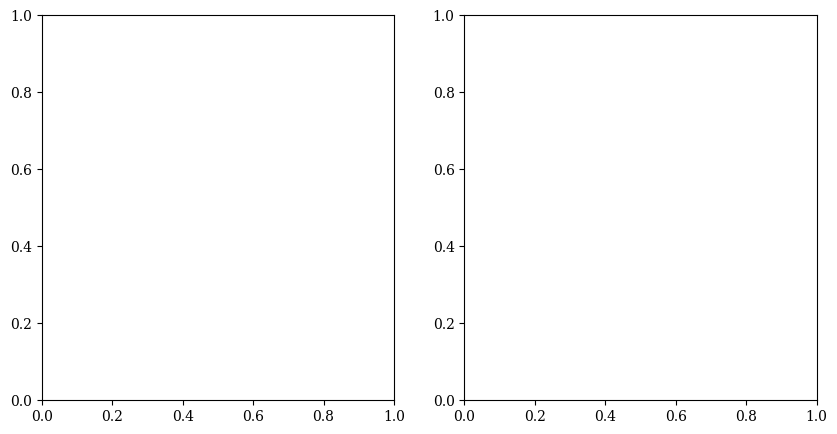

In [29]:
# def sns_vial(data):
plt.rcParams['font.family'] = 'serif'

plt.figure(facecolor='white')
palette = sns.color_palette("husl",3)  # 选择一个调色板

# boxprops = dict(edgecolor= "gray", linewidth=1.5)
# whiskerprops = dict(color= "gray", linewidth=1.5)
# capprops = dict(color= "gray", linewidth=1.5)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

# box1 = sns.boxplot(x='entropy', y='Var', data=em_js, palette = palette, width=0.4,
                   #   boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
box1 = sns.boxplot(x='num_class', y = 'accuracy', data=df_melted_acc,  palette = palette,width=0.3, ax=axs[0])
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
median_color = "yellow"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
axs[0].set_ylabel('Accuracy', fontsize = 14, fontweight='semibold')
axs[0].set_xlabel('Number of Emotion Types', fontsize = 14, fontweight='semibold')
# plt.tick_params(axis='both', which='major', labelsize=14)

box2 = sns.boxplot(x='num_class', y = 'F1_score', data=df_melted_f1,  palette = palette,width=0.3, ax=axs[1])
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
for i in [4, 10, 16]: 
    box2.get_lines()[i].set_color(median_color)
    box2.get_lines()[i].set_linewidth(2)
axs[1].set_ylabel('F1 score', fontsize = 14,  fontweight='semibold')
axs[1].set_xlabel('Number of Emotion Types', fontsize = 14, fontweight='semibold')
# axs[1].set_title("F1 score in five runs by number of emotion types", fontsize = 14, fontweight='medium')
# plt.tick_params(axis='both', which='major', labelsize=14)

#sns.despine(left=True)

plt.show()

# df_melted_acc.boxplot(column='accuracy', by='num_class', grid=False)

In [ ]:
# Melt the data to long format
df_melted_acc = tt_m.melt(id_vars=['num_class'], value_vars=['acc1', 'acc2', 'acc3', 'acc4', 'acc5'], 
                    var_name='accuracy_type', value_name='accuracy')

import plotly.express as px
df_melted_acc['num_class'] = df_melted_acc['num_class'].astype(str)
df_melted_acc = df_melted_acc.sort_values(by='num_class')

df_melted_f1 = tt_m.melt(id_vars=['num_class'], value_vars=['f11', 'f12', 'f13', 'f14', 'f15'],
                    var_name='f1_type', value_name='F1_score')
df_melted_f1['num_class'] = df_melted_f1['num_class'].astype(str)
df_melted_f1 = df_melted_f1.sort_values(by='num_class')
# Create the boxplot using Plotly
# fig = px.scatter(df_melted_acc, x='num_class', y='accuracy', title='Points plot of Accuracy by Number of Emotion Types')
# # Show the plot
# fig.show()

In [31]:
# Melt the data to long format
df_melted_acc = tt_m.melt(id_vars=['entropy'], value_vars=['acc1', 'acc2', 'acc3', 'acc4', 'acc5'], 
                    var_name='accuracy_type', value_name='accuracy')

import plotly.express as px
df_melted_acc['entropy'] = df_melted_acc['entropy'].astype(str)
df_melted_acc = df_melted_acc.sort_values(by='entropy')

In [32]:
# Create the boxplot using Plotly
fig = px.scatter(df_melted_acc, x='entropy', y='accuracy', title='Points plot of Accuracy by Entropy Group')
# Show the plot
fig.show()

In [33]:
# Melt the data to long format
df_melted_f1 = tt_m.melt(id_vars=['entropy'], value_vars=['f11', 'f12', 'f13', 'f14', 'f15'], 
                    var_name='accuracy_type', value_name='F1_score')

df_melted_f1['entropy'] = df_melted_f1['entropy'].astype(str)
df_melted_f1 = df_melted_f1.sort_values(by='entropy')

fig = px.scatter(df_melted_f1, x='entropy', y='F1_score', title='Boxplot of Accuracy by Entropy Group')
fig.show()

In [30]:
df_melted

NameError: name 'df_melted' is not defined

In [ ]:
em_js

,entropy,JS1,JS2,JS3,JS4,JS5,mean,Var
0,0.9710,0.523784,0.523784,0.523784,0.523784,0.523784,0.523784,0.000000
1,0.9710,0.523784,0.523784,0.523784,0.523784,0.523784,0.523784,0.000000
2,0.9710,0.557898,0.832526,0.832526,0.832526,0.753691,0.761833,0.014162
3,0.7219,0.273679,0.273679,0.273679,0.273679,0.273679,0.273679,0.000000
4,0.7219,0.273679,0.273679,0.273679,0.273679,0.273679,0.273679,0.000000
...,...,...,...,...,...,...,...,...
3921,0.9710,0.523784,0.523784,0.523784,0.523784,0.523784,0.523784,0.000000
3922,0.7219,0.650231,0.650231,0.650231,0.650231,0.650231,0.650231,0.000000
3923,0.0000,0.832526,0.832526,0.832526,0.832526,0.832526,0.832526,0.000000
3924,0.9710,0.434051,0.463843,0.463843,0.463843,0.404784,0.446073,0.000699
